In [1]:
from itertools import combinations
from random import sample

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import DBSCAN
from pyproj import Geod

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import distance

# Sketch

1. Identify a depot and nodes to serve
2. Get VRP solution routes given the depot and nodes to serve for different # of vehicles used in the VRP solution
3. Generate the minimum cost to add an OD for each OD pair in the network, for each # of vehicles used in the VRP solutions
    * Find the minimum cost by taking each route in the solution and finding the cost to detour to the origin of the request between consecutive nodes in the VRP solution. Do the same in the reverse direction with the destination node. Find the lowest cost pair of diversions. \[Kind of complicated to implement. Let's skip this.\]
    * Alternatively, find the lowest cost detour to the origin. Given this new route, find the lowest cost to detour to the destination on the subset of the new route that comes after the new origin.
4. Using sklearn.cluster.DBSCAN and different percentages of all min costs randomly sampled from the OD matrix, see if DBSCAN can correctly identify the number of vehicles. Do so in two ways:
    * Assign real-world lat-longs to each node. For each request, take the geographic midpoint of the request line. Cluster on these points.
    * For each OD pair, split the cost in half between the origin and the destination. Cluster on these points using the distance matrix (i.e., lat-longs not required). \[Seems like not enough points.\]

# Compile information

Let's first setup the problem. We'll start with getting information on all the nodes in our model.

## Translate city to latlong

In [2]:
try:
    cities = pd.read_csv('city_locs.csv', index_col=0)
except FileNotFoundError:
    cities = pd.read_excel('Model2 Input_NEW.xlsx', sheet_name='Node Sets', skiprows=10, usecols=[5,6], header=0, index_col=0)
    cities.dropna(inplace=True)
    geolocator = Nominatim()
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    cities['Location'] = cities['Description'].apply(geocode)
    cities['lat'] = cities['Location'].apply(lambda x: x.latitude)
    cities['lon'] = cities['Location'].apply(lambda x: x.longitude)
    cities.drop('Location', axis=1, inplace=True)
    cities.to_csv('city_locs.csv')
cities.head()

,Description,lat,lon
Node,,,
D1,"York, PA",39.962398,-76.727392
O1,"Orlando, FL",28.542110,-81.379039
O2,"Troy, OH",40.039498,-84.203277
O3,"Palmyra, PA",40.308858,-76.593237
O4,"Oneonta, NY",42.453492,-75.062953


## Distance (transportation costs) matrix

Our network is fully connected.

In [3]:
dm = pd.read_excel('Model2 Input_NEW.xlsx', sheet_name='Transportation Costs Input', skiprows=4, usecols=list(range(1,108)), header=0, index_col=0)
# could alternately use 'Arc Time Length Input'
dm.replace(dm.max(), 0, inplace=True)
dm.head()

,D1,O1,O2,O3,O4,O5,O6,O7,O8,O9,...,B36,B37,B38,B39,B40,B41,B42,B43,B44,B45
D1,0.0,1507.2,734.4,62.4,422.4,169.6,416.0,198.4,460.8,753.6,...,16.0,163.2,152.0,163.2,163.2,40.0,40.0,16.0,16.0,40.0
O1,1507.2,0.0,1556.8,1566.4,1924.8,1675.2,1899.2,1592.0,1222.4,1512.0,...,1516.8,1596.8,1612.8,1596.8,1596.8,1545.6,1545.6,1516.8,1516.8,1545.6
O2,734.4,1556.8,0.0,721.6,980.8,803.2,622.4,915.2,995.2,51.2,...,745.6,880.0,868.8,880.0,880.0,716.8,716.8,745.6,745.6,716.8
O3,62.4,1566.4,721.6,0.0,368.0,112.0,358.4,184.0,512.0,753.6,...,59.2,148.8,137.6,148.8,148.8,28.8,28.8,59.2,59.2,28.8
O4,422.4,1924.8,980.8,368.0,0.0,260.8,361.6,419.2,784.0,1022.4,...,387.2,384.0,372.8,384.0,384.0,379.2,379.2,387.2,387.2,379.2


In [4]:
# symmetry check
(dm != dm.T).sum().sum() == 0

False

## Dictionary of node names to IDs

For the most part we refer to nodes by an integer ID instead of its two letter code, so let's make it so we can translate between the two easily.

In [5]:
node_to_id = dict([(dm.index[i],i) for i in range(len(dm.index))])
id_to_node = dict([(v,k) for k,v in node_to_id.items()])
id_to_node[len(dm.index)] = 'D1' # routes start and end at depot node D1, so we registered it as both the lowest ID and highest ID nodes
nnode = len(node_to_id)
print(node_to_id['B45'], id_to_node[105])

105 B45


## Generate network model and plot

The cities range from in New York to western Pennsylvania to Florida, so the map should end up looking tall and skinny.

In [6]:
# not symmetric, so we need a DAG
G = nx.from_numpy_matrix(dm.values, create_using=nx.DiGraph())
G = nx.relabel_nodes(G, dict(zip(range(dm.shape[0]), dm.index.values)))
for k,v in cities.to_dict(orient='index').items():
    G.nodes[k].update(v)
# G = nx.set_node_attributes(G, cities.to_dict(orient='index'))

print(G['D1']['O1'])
print(G['O3']['O1'])
print(G.nodes['D1'])

{'weight': 1507.2}
{'weight': 1566.4}
{'Description': 'York, PA', 'lat': 39.962398, 'lon': -76.72739200000001}


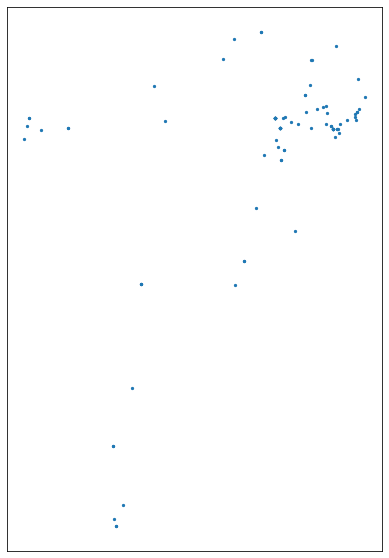

In [7]:
aspect_ratio = (cities['lon'].max()-cities['lon'].min())/(cities['lat'].max()-cities['lat'].min())
plt.figure(figsize=(10*aspect_ratio, 10))
nx.draw_networkx_nodes(G, pos=dict((n,(a['lon'], a['lat'])) for n,a in G.nodes(data=True)), node_size=5)
plt.show()

## VRP solutions

These were pregenerated to visit all nodes for the lowest accumulated cost given some set of parameters. Aside from the one-vehicle solution, the routes are close but not guaranteed to be optimal.

The solution to the 5, 10, and 15 vehicle problems were generated by preallocating the number of vehicles, requiring that every vehicle visit at least 4 nodes, and setting a time limit of 200 hours.

The 1-vehicle solution is to the unconstrained problem.

In [8]:
sols = {} # key is number of vehicles used in the corresponding VRP solution

sols[1] = [
    [0, 96, 83, 103, 104, 70, 92, 71, 44, 49, 50, 84, 90, 85, 68, 101, 93, 105, 94, 79, 102, 89, 91, 69, 67, 81, 87, 88, 48, 3, 52, 51, 46, 58, 98, 95, 72, 27, 75, 77, 76, 99, 57, 74, 100, 78, 97, 73, 15, 7, 11, 29, 10, 28, 30, 33, 32, 31, 34, 38, 56, 5, 55, 14, 53, 54, 59, 25, 22, 65, 23, 13, 12, 24, 60, 8, 62, 63, 26, 66, 61, 64, 21, 16, 17, 1, 18, 19, 20, 9, 2, 40, 41, 43, 39, 42, 86, 47, 6, 37, 36, 35, 82, 4, 80, 45, 106]
]

sols[5] = [
    [0, 44, 49, 89, 69, 90, 52, 25, 22, 23, 65, 13, 12, 24, 60, 8, 62, 63, 26, 66, 64, 61, 21, 17, 16, 1, 18, 19, 20, 7, 106],
    [0, 103, 50, 87, 81, 94, 51, 46, 58, 95, 74, 106],
    [0, 70, 96, 84, 102, 68, 85, 106],
    [0, 71, 104, 79, 67, 91, 48, 3, 59, 54, 14, 53, 45, 98, 57, 27, 75, 77, 100, 97, 72, 99, 78, 76, 73, 15, 11, 29, 10, 28, 30, 32, 33, 31, 34, 38, 56, 55, 5, 80, 4, 82, 36, 35, 37, 6, 47, 40, 41, 2, 9, 43, 42, 39, 86, 106],
    [0, 83, 92, 93, 101, 88, 105, 106]
]

sols[10] = [
    [0, 50, 91, 48, 52, 106],
    [0, 104, 81, 67, 46, 58, 95, 98, 73, 27, 77, 106],
    [0, 49, 84, 102, 51, 106],
    [0, 70, 68, 87, 54, 14, 53, 31, 32, 33, 30, 34, 7, 60, 8, 63, 62, 26, 21, 16, 17, 1, 18, 20, 19, 64, 66, 61, 106],
    [0, 44, 93, 88, 22, 13, 106],
    [0, 83, 90, 59, 45, 11, 29, 10, 28, 75, 72, 76, 99, 57, 74, 100, 78, 97, 15, 106],
    [0, 103, 79, 89, 5, 56, 38, 106],
    [0, 71, 69, 94, 65, 23, 12, 24, 106],
    [0, 92, 105, 3, 55, 80, 4, 82, 36, 35, 37, 6, 47, 86, 42, 39, 43, 2, 40, 41, 9, 106],
    [0, 96, 85, 101, 25, 106]
]

sols[15] = [
    [0, 69, 88, 5, 56, 80, 4, 82, 35, 36, 37, 6, 47, 39, 42, 43, 40, 41, 2, 9, 86, 89, 106],
    [0, 50, 87, 76, 7, 106],
    [0, 84, 101, 14, 53, 34, 106],
    [0, 71, 67, 57, 74, 106],
    [0, 93, 81, 55, 38, 106],
    [0, 83, 68, 72, 11, 106],
    [0, 79, 90, 48, 73, 27, 106],
    [0, 103, 91, 24, 60, 8, 62, 63, 26, 66, 61, 64, 21, 17, 1, 18, 19, 20, 16, 106],
    [0, 102, 105, 3, 78, 15, 106],
    [0, 92, 85, 45, 28, 30, 106],
    [0, 70, 51, 46, 58, 95, 98, 99, 77, 75, 97, 10, 106],
    [0, 104, 94, 100, 29, 106],
    [0, 49, 65, 23, 13, 106],
    [0, 96, 52, 59, 54, 31, 33, 32, 106],
    [0, 44, 25, 22, 12, 106]
]

## Plot routes

/home/carlin/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/carlin/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/carlin/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/home/carlin/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(n

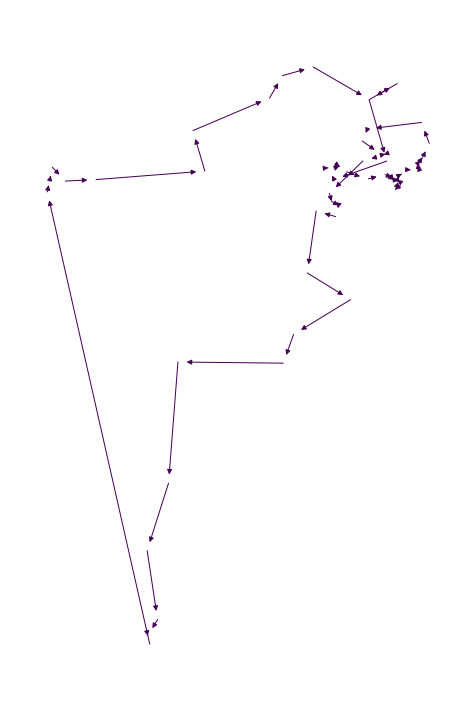

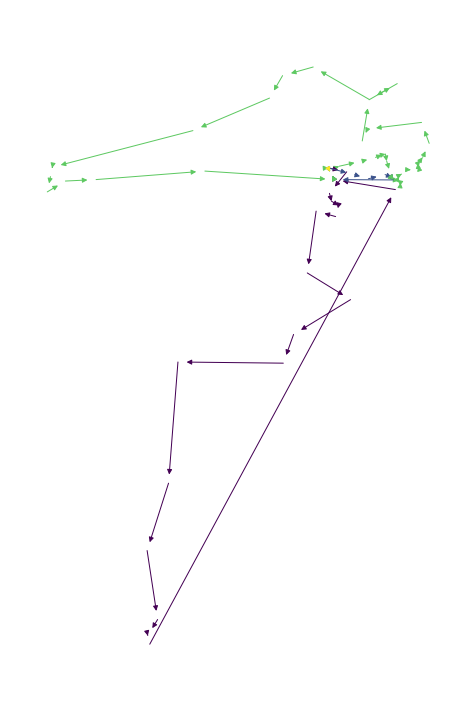

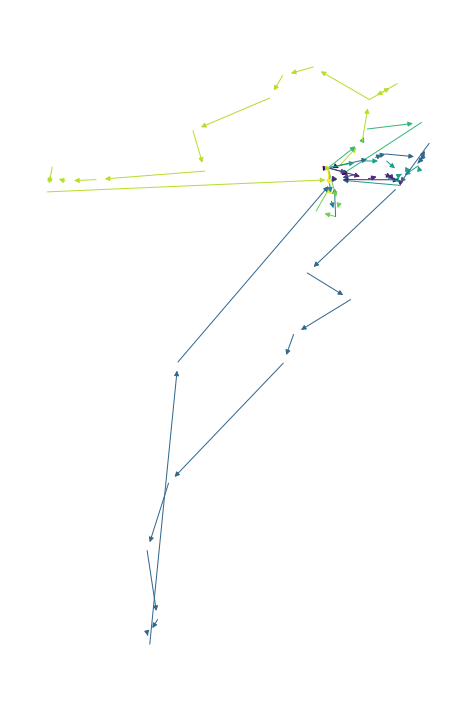

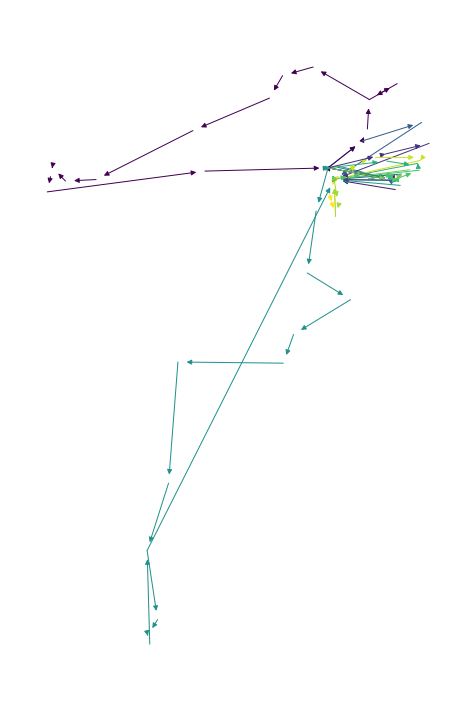

In [9]:
def plot_routes(routes, figname=None, return_axes=False):
    Gplot = nx.create_empty_copy(G, with_data=True)
    for i,route in enumerate(routes):
        for n1,n2 in zip(route, route[1:]):
            Gplot.add_edge(id_to_node[n1], id_to_node[n2], route=i)
            
    plt.figure(figsize=(10*aspect_ratio,10))    
    nx.draw_networkx_edges(Gplot,
                           pos=dict((n,(a['lon'], a['lat'])) for n,a in Gplot.nodes(data=True)),
                           edge_color=[a['route'] for _,_,a in Gplot.edges(data=True)])
    plt.axis('off')
    plt.tight_layout()
    if return_axes:
        return plt.gca()
    if figname:
        plt.savefig(figname, dpi='figure')
    plt.show()

for v,sol in sols.items():
    plot_routes(sol, f'output/routes_{v}v.png')

# Generate minimum costs to serve each OD pair for each solution

Use a reasonable heuristic to find the minimum cost of adding an OD request to one of a few set, fixed routes. Do so by finding the lowest cost detour to the origin and back onto the route for a given route. Given this new route, find the lowest cost to detour to the destination on the subset of the new route that comes after the new origin. Repeat for all routes (vehicles) in a VRP solution and take the lowest cost among all routes. Repeat for all VRP solutions.

In [10]:
mincosts_for = {}

try:
    for vehs in sols:
        mincosts_for[vehs] = pd.read_csv(f'processed/mincosts_{vehs}v.csv', index_col=0)
except FileNotFoundError:
    for vehs in sols:
        # copy distance matrix. we'll be writing over every entry anyway.
        mincosts_for[vehs] = dm.copy()

    for o in range(nnode): # origin O of request
        for d in range(nnode): # destination D of request
            for vehs in sols: # VRP solution (index by # of vehicles used) we're calculating the mincost of detouring to OD for
                if o == d: # ignore starting and ending at the same node
                    mincosts_for[vehs].iloc[o,d] = np.nan
                else:
                    mincost = None
                    for route in sols[vehs]: # 
                        lowest_cost_origin_detour = 0 # so detour after the node listed at position 0
                        origin_detour_cost = dm.iloc[route[0], o] + dm.iloc[o, route[1]] 

                        # find the lowest cost to insert the origin
                        for (i, (n1, n2)) in enumerate(zip(route, route[1:])):
                            if n2 == nnode: # depot node at end of route
                                cost = dm.iloc[n1, o] + dm.iloc[o, 0]
                            else:
                                cost = dm.iloc[n1, o] + dm.iloc[o, n2]
                            if cost < origin_detour_cost:
                                lowest_cost_origin_detour = i-1
                                origin_detour_cost = cost

                        # given we found somewhere to insert the origin, find the lowest cost to insert the destination
                        changed_route = [o] + route[lowest_cost_origin_detour+1:]
                        destin_detour_cost = dm.iloc[o, d] + dm.iloc[d, changed_route[1]]
                        od_consecutive = True # if D comes after O, we need to calculate the mincost differently
                        for (i, (n1,n2)) in enumerate(zip(changed_route, changed_route[1:])):
                            if n2 == nnode: # depot node at end of route
                                cost = dm.iloc[n1, d] + dm.iloc[d, 0]
                            else:
                                cost = dm.iloc[n1, d] + dm.iloc[d, n2]
                            if cost < destin_detour_cost:
                                destin_detour_cost = cost
                                od_consecutive = False

                        if od_consecutive:
    #                         if o == 0:
    #                             lowest = destin_detour_cost
    #                         else:
                            lowest = dm.iloc[lowest_cost_origin_detour, o] + destin_detour_cost
                        else:
                            lowest = origin_detour_cost + destin_detour_cost

                        if (mincost is None) or (lowest < mincost):
                            mincost = lowest

                    mincosts_for[vehs].iloc[o,d] = mincost

    for vehs,mincosts in mincosts_for.items():
        mincosts.to_csv(f'processed/mincosts_{vehs}v.csv')

mincosts_for[15].head()

,D1,O1,O2,O3,O4,O5,O6,O7,O8,O9,...,B36,B37,B38,B39,B40,B41,B42,B43,B44,B45
D1,NaN,78.4,72.0,68.8,142.4,92.8,129.6,52.8,169.6,91.2,...,16.0,28.8,24.0,28.8,41.6,48.0,48.0,16.0,16.0,48.0
O1,1342.4,NaN,2174.4,1456.0,2233.6,1728.0,2145.6,1601.6,1518.4,2163.2,...,1364.8,1592.0,1596.8,1592.0,1592.0,1417.6,1417.6,1364.8,1364.8,1417.6
O2,72.0,1524.8,NaN,123.2,833.6,329.6,784.0,438.4,982.4,83.2,...,88.0,364.8,344.0,364.8,364.8,80.0,80.0,88.0,88.0,80.0
O3,97.6,150.4,89.6,NaN,160.0,110.4,147.2,104.0,241.6,108.8,...,113.6,65.6,73.6,65.6,65.6,65.6,67.2,113.6,113.6,67.2
O4,142.4,828.8,134.4,193.6,NaN,400.0,192.0,508.8,920.0,153.6,...,158.4,435.2,414.4,435.2,435.2,150.4,150.4,158.4,158.4,150.4


In [11]:
for mincosts in mincosts_for.values():
    print(mincosts.max().max())

3913.6
3220.8
2579.2
2592.0


## Enable random sampling of minimum costs by OD pair

We only want OD pairs to be selected at most once so let's make a list of all possible OD pairs and then take random proportions (or counts) of this list to give us our sample.

In [12]:
all_valid_id_pairs = combinations(dm.index.values, 2)
all_valid_id_pairs = [pair for pair in all_valid_id_pairs if (pair[0] != pair[1])]
print('Total population size:', len(all_valid_id_pairs))

def make_sampled_indices(n=None, p=0.1):
    if n and p:
        raise ValueError('Can only use n or p parameters, not both.')
    elif p:
        n = int((p*len(all_valid_id_pairs)))
    return sample(all_valid_id_pairs, n)

make_sampled_indices(p=0.001)

Total population size: 5565


[('O13', 'B32'), ('P25', 'P32'), ('O14', 'P42'), ('B13', 'B40'), ('O9', 'P6')]

## Turn OD pair into its midpoint

In [13]:
geoid = Geod(ellps="WGS84")

def create_X_row(o, d):
    olonlat = cities.loc[o, ['lon', 'lat']].values
    dlonlat = cities.loc[d, ['lon', 'lat']].values
    midpoint = geoid.npts(cities.loc[o, 'lon'],
                          cities.loc[o, 'lat'],
                          cities.loc[d, 'lon'],
                          cities.loc[d, 'lat'],
                          1)[0]
    return np.array(midpoint)

o, d = make_sampled_indices(n=1, p=None)[0]
create_X_row(o, d)

array([-76.70729224,  39.48210921])

## Plot all points

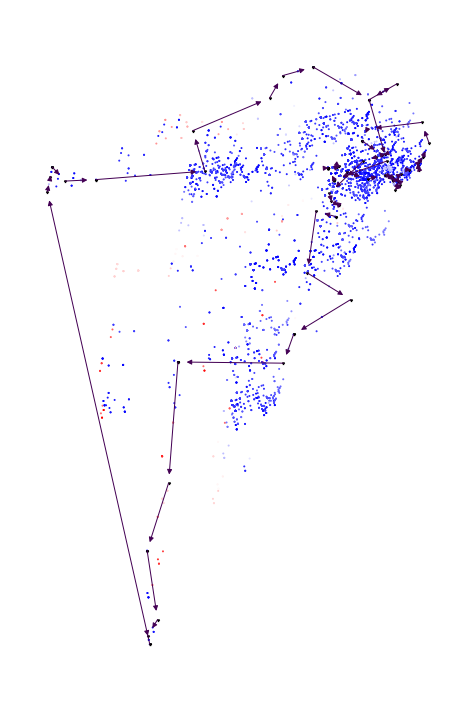

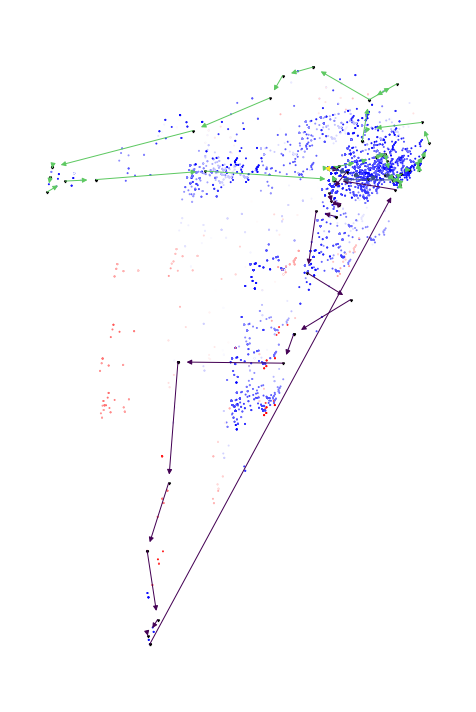

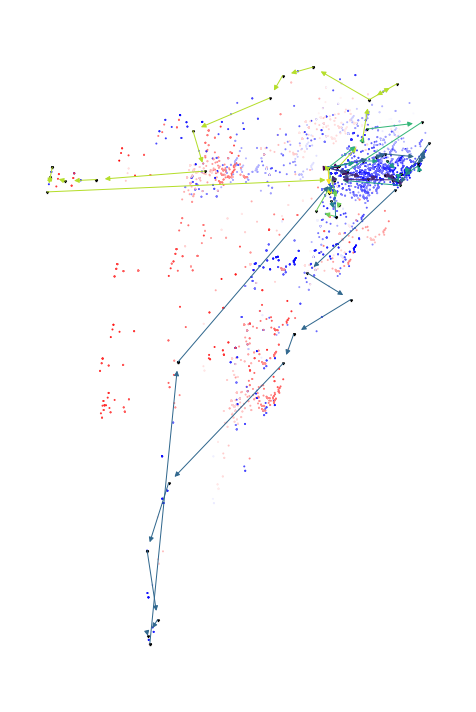

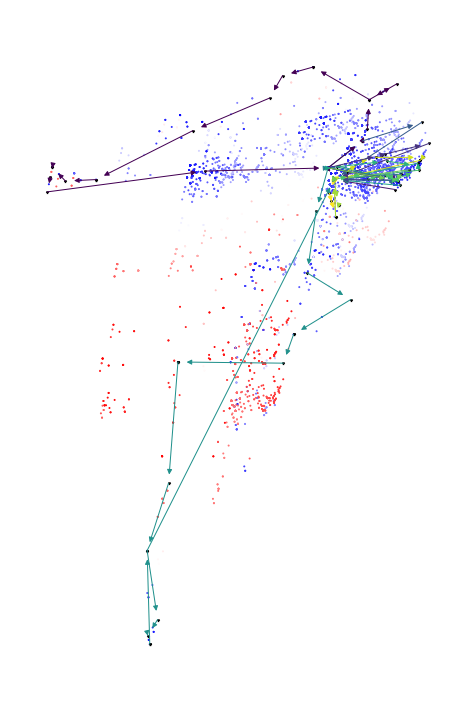

In [14]:
def plot_requests_and_routes(veh_count):
    pt_list = make_sampled_indices(p=1)
    all_points = np.array([create_X_row(p[0], p[1]) for p in pt_list])
    all_costs = np.array([mincosts_for[veh_count].loc[p] for p in pt_list])
    # plt.figure(figsize=(10*aspect_ratio, 10))
    # plt.axis('off')
    cf = plt.get_cmap('bwr')
    # plt.scatter(all_points[:,0], all_points[:,1], c=cf(all_costs/all_costs.max()), s=1)
    plt.sca(plot_routes(sols[veh_count], return_axes=True))
    plt.scatter(all_points[:,0], all_points[:,1],
                c=cf(1-(1-all_costs/all_costs.max())**2), # exaggerate colors on the low side a little
                s=1, marker='o')
    plt.scatter(cities['lon'], cities['lat'], c='k', s=10, marker='1')
    plt.tight_layout()
    plt.savefig(f'output/request_costs_{veh_count}.png', dpi='figure')
    plt.show()

for veh in sols:
    plot_requests_and_routes(veh)

# Density-based clustering 

Using sklearn.cluster.DBSCAN and different percentages of all min costs randomly sampled from the OD matrix, we'll see if DBSCAN can correctly identify the number of vehicles. Do so in two ways:
    * Assign real-world lat-longs to each node. For each request, take the geographic midpoint of the request line. Cluster on these points.
    * For each OD pair, split the cost in half between the origin and the destination. Cluster on these points using the distance matrix (i.e., lat-longs not required).

Some thoughts about DBSCAN parameters:
* `eps`: "The maximum distance between two samples for one to be considered as in the neighborhood of the other." Any two points in a network can be neighbors, especially if there's only one vehicle in the VRP solution.
* more tbd

In [15]:
X = []
weights = []
for o,d in make_sampled_indices(p=0.001):
    X.append(create_X_row(o,d))
    weights.append(mincosts_for[15].loc[o,d])
X = np.array(X)
X.shape

(5, 2)

In [16]:
# clusterings = {
#     'latlong': {},
#     'dmatrix': {}
# }
# for vehs, mincosts in mincosts_for.items():
#     # DBSCAN data input method 1: turn requests into center points
#     clusterings[][vehs] = DBSCAN(
        
#     )
    
#     # DBSCAN data input method 2: split requests into half and allocate between O and D

cl = DBSCAN(
    metric = 'precomputed',
    eps = dm.replace(dm.max(), np.nan).max().max()-100
)

wts = mincosts_for[15].sum(axis=1, skipna=True)
cl.fit(dm.values, sample_weight=-1*wts/wts.max()+.25)

print(len(set(cl.labels_)) - (1 if -1 in cl.labels_ else 0))

1


In [17]:
cl.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0])